# Load Libraries

In [8]:
## Basic dependencies
import numpy as np
from numpy import loadtxt, savetxt

import pandas as pd
import math
import time
from datetime import date
# print options
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

####################################################################################

## Statistical analysis
# PCA
from sklearn.decomposition import PCA

#####################################################################################

## torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

######################################################################################################

## Optimisation & DoE
# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch import fit_gpytorch_mll

# utilities
from botorch.optim.optimize import optimize_acqf,optimize_acqf_list
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.sampling import sample_simplex
from torch.optim import SGD
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement

# LHS
from pyDOE import lhs

# Warnings
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

##############################################################################################################

# plotting dependencies
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.lines as lines

# Load Dataset

In [16]:
df_training_full = pd.read_pickle('Training_Dataset_all_rings.pkl')
df_training_full

diameter  pitch  nQWs  growt_T_qw  growt_AsP_qw  \
sample_ID field_ID ring_ID                                                    
127       1        1             4.0    7.5   8.0       600.0          0.92   
                   2             4.0    7.5   8.0       600.0          0.92   
                   3             4.0    7.5   8.0       600.0          0.92   
                   4             4.0    7.5   8.0       600.0          0.92   
                   5             4.0    7.5   8.0       600.0          0.92   
...                              ...    ...   ...         ...           ...   
348       9        684           7.0   14.0   8.0       600.0          0.92   
                   685           7.0   14.0   8.0       600.0          0.92   
                   686           7.0   14.0   8.0       600.0          0.92   
                   687           7.0   14.0   8.0       600.0          0.92   
                   688           7.0   14.0   8.0       600.0          0.92   

                            growt_InP_br  growt_t_cap  lasing_threshold  \
sample_ID field_ID ring_ID                                                
127       1        1               0.036        240.0        555.182977   
                   2               0.036        240.0        625.516448   
                   3               0.036        240.0        478.395951   
                   4               0.036        240.0        341.370816   
                   5               0.036        240.0        471.635147   
...                                  ...          ...               ...   
348       9        684             0.048        180.0        172.587603   
                   685             0.048        180.0        137.148452   
                   686             0.048        180.0        282.760118   
                   687             0.048        180.0        456.352368   
                   688             0.048        180.0               NaN   

                              lasing_wl     Yield  
sample_ID field_ID ring_ID                         
127       1        1         955.247097  0.691667  
                   2         951.586050  0.691667  
                   3         988.256789  0.691667  
                   4        1054.454223  0.691667  
                   5         984.712054  0.691667  
...                                 ...       ...  
348       9        684      1115.003906  0.937500  
                   685      1114.283906  0.937500  
                   686      1044.249215  0.937500  
                   687      1011.694189  0.937500  
                   688              NaN  0.937500  

[4128 rows x 10 columns]

In [76]:
# Prepare dataset for optimization
# Group by field_ID
grouped = df_training_full.groupby(['sample_ID','field_ID'])

# Calculate median for each feature and objectives except yield. 
# Yield was defined as the ratio of MRs that exhibited lasing to the total number of MRs in that field.
result_training = grouped.agg(
    Lasing_threshold = ('lasing_threshold', 'median'),
    Lasing_wl=('lasing_wl', 'median'),
    Yield = ('lasing_threshold', lambda x: x.notna().sum() / len(x)),
    diameter = ('diameter','median'),
    nQWs = ('nQWs','median'),
    pitch = ('pitch','median'),
    growt_T_qw	 = ('growt_T_qw','median'),
    growt_AsP_qw = ('growt_AsP_qw','median'),
    growth_InP_br_V_III = ('growt_InP_br','median'),
    growt_t_cap = ('growt_t_cap','median'), 
    ).reset_index()


# Add 'pitch-diam' column as the difference between 'pitch' and 'diameter' 
result_training['pitch-diam'] = result_training['pitch'] - result_training['diameter']
result_training = result_training.drop(columns='pitch') # Drop 'pitch' column

# Convert V/III percentages into ratios
result_training['growth_InP_br_V_III'] = result_training['growth_InP_br_V_III'].apply(
    lambda x: 1500 if np.isclose(x, 0.036, atol=1e-5) else (2000 if np.isclose(x, 0.048, atol=1e-5) else x)
)

# Drop 'NaN' values if any
result_training = result_training.dropna()

# Rearrange columns 
column_order = [
    'Lasing_threshold', 'Lasing_wl', 'Yield', 'diameter', 'nQWs', 'pitch-diam', 
    'growt_T_qw', 'growt_AsP_qw', 'growth_InP_br_V_III', 'growt_t_cap']
    
df = result_training[column_order]

# Display the result
df

,Lasing_threshold,Lasing_wl,Yield,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,429.543520,975.402386,0.691667,4.0,8.0,3.5,600.0,0.92,1500,240.0
1,165.291290,1108.835640,0.975000,6.0,8.0,4.0,600.0,0.92,1500,240.0
2,178.826444,1126.766994,0.982143,8.0,8.0,4.0,600.0,0.92,1500,240.0
3,115.509624,1145.089956,1.000000,10.0,8.0,3.0,600.0,0.92,1500,240.0
4,230.302087,1087.967338,0.975000,5.0,8.0,2.5,600.0,0.92,1500,240.0
5,166.608105,1118.746162,0.950000,7.0,8.0,3.0,600.0,0.92,1500,240.0
6,114.002966,1148.685686,0.964286,9.0,8.0,3.0,600.0,0.92,1500,240.0
7,331.295646,1048.413342,0.912500,5.0,8.0,5.0,600.0,0.92,1500,240.0
8,150.252752,1176.648591,0.916667,7.0,8.0,7.0,600.0,0.92,1500,240.0
10,208.843722,953.924534,0.250000,6.0,5.0,4.0,600.0,0.66,2000,120.0


# Define Objectives, Parameters and Bounds

In [77]:
random_state = 42 
torch.manual_seed(random_state) # Gives a consistent seed based on the trial number

# Define number of features and objectives
n_var = 7 # Number of X values(Features)  i.e. the number of growth & geometry parameters
n_obj = 3 # Number of y values(objectives) values i.e. Threshold, Wavelength and Yield

train_x = torch.tensor(df[df.columns[n_obj:]].to_numpy(), **tkwargs)
train_obj = torch.tensor(df[['Lasing_threshold', 'Lasing_wl', 'Yield']].to_numpy(), **tkwargs)
# Minimize threshold and maximize yield and wavlength

train_obj[:, 0] = -train_obj[:, 0] # Botorch uses maximisation so negate it as we want to minimize threshold

# Define Problem bounds for each X values. This information is obtained through domain experts.
lower_bounds = torch.tensor([4, 1, 2, 590, 0.6, 1500, 60 ], **tkwargs) 
upper_bounds = torch.tensor([15, 12, 15, 620, 1.1, 4000, 240], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

# Standard bounds i.e. 0 and 1 for normalization
standard_bounds = torch.zeros(2, train_x.shape[1], **tkwargs)
standard_bounds[1] = 1

# Normalize
train_x_norm = normalize(train_x, problem_bounds)

print('Objective Tensor Shape:',train_obj.shape, '\nFeatures Tensor Shape:',train_x.shape)

Objective Tensor Shape: torch.Size([53, 3]) 
Features Tensor Shape: torch.Size([53, 7])


# Multi-Objective Bayesian Optimisation

## GP Regression

In [78]:
## Train Gaussian process regression model

models = [] 
for i in range(train_obj.shape[-1]): # 3 seperate models for each objective
    train_y = train_obj[..., i : i + 1]
    models.append(SingleTaskGP(train_x_norm, train_y, outcome_transform=Standardize(m=1)))
model = ModelListGP(*models) # Stack models
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll) # Fit model

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-2): 3 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-2): 3 x SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): GammaPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): ScaleKernel(
          (base_kernel): MaternKernel(
            (lengthscale_prior): GammaPrior()
            (raw_lengthscale_constraint): Positive()
          )
          (outputscale_prior): GammaPrior()
          (raw_outputscale_constraint): Positive()
        )
        (outcome_transform): Standardize()
      )
    )
    (likelihood): LikelihoodList

In [79]:
## Model Predictions
train_X=train_x_norm
train_Y=train_obj

with torch.no_grad():
    y_true = train_Y
    posterior = model.posterior(train_X)  
    y_pred = posterior.mean.squeeze()
    lower, upper = posterior.mvn.confidence_region() 
    yerr = upper-lower
     

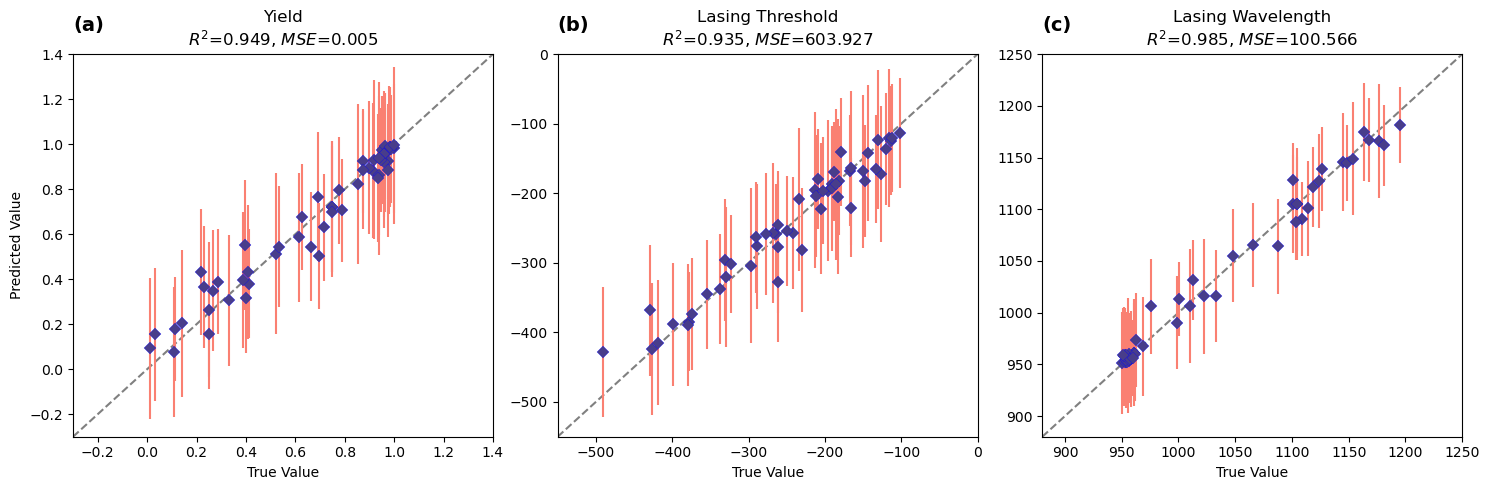

In [80]:
# Check how well model fit the data
# Reordering the columns
train_Y_reordered = train_Y[..., [2, 0, 1]]  # Reorder to [Yield, Threshold, Wavelength]
y_pred_reordered = y_pred[..., [2, 0, 1]]
yerr_reordered = yerr[..., [2, 0, 1]]

# Calculate R^2 and MSE for each objective
r2_vals = []
mse_vals = []

for i in range(3):
    y_true_calc = train_Y_reordered[..., i].cpu().numpy()
    y_pred_calc = y_pred_reordered[..., i].cpu().numpy()
    mse = np.mean((y_true_calc - y_pred_calc) ** 2) # mse calculation
    r2 = 1 - (np.sum((y_true_calc - y_pred_calc) ** 2) / np.sum((y_true_calc - np.mean(y_true_calc)) ** 2)) # R2 calculation
    mse_vals.append(mse)
    r2_vals.append(r2)


# Plotting the graphs
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

for i, (obj, r2, mse) in enumerate(zip(["Yield", "Lasing Threshold", "Lasing Wavelength"], r2_vals, mse_vals)):
    
    ax[i].axline((1, 1), slope=1, color='gray', linestyle='--')
    # Errobars
    ax[i].errorbar(x=train_Y_reordered[...,i].cpu().numpy(), 
                   y=y_pred_reordered[...,i].cpu().numpy(),
                   yerr=yerr_reordered[...,i].cpu().numpy(),
                   ls='', marker='D', mec='b', mew=0.2, mfc='darkslateblue', c='salmon')
    
    ax[i].set_title(f"{obj}\n$R^2$={r2:.3f}, $MSE$={mse:.3f}")
    ax[i].set_xlabel('True Value')
    # Add subplot labels (a), (b), (c)
    ax[i].text(0, 1.1, f'({chr(97 + i)})', transform=ax[i].transAxes, 
               fontsize=14, fontweight='bold', va='top')

ax[0].set_ylabel('Predicted Value')

# Set Wavelength limit from 800 to 1400
ax[2].set_xlim([880, 1250])
ax[2].set_ylim([880, 1250])

ax[0].set_xlim([-0.3, 1.4])
ax[0].set_ylim([-0.3, 1.4])

ax[1].set_xlim([-550, 0])
ax[1].set_ylim([-550, 0])


fig.tight_layout()

plt.show()


## Acquisition using qNParEGO

In [274]:

BATCH_SIZE = 50 # Define desired number of candidates 
MC_SAMPLES = 128
NUM_RESTARTS = 10
RAW_SAMPLES = 512

with torch.no_grad():
    pred = model.posterior(train_x_norm).mean # Get mean prediction

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES])) # Generate samples
# We are using qNParEGO    
acq_func_list = []
for _ in range(BATCH_SIZE):
    weights = sample_simplex(n_obj, **tkwargs).squeeze()
    objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred)) #Scalarization for qNParEGO
    # Acquisition
    acq_func = qNoisyExpectedImprovement(
        model=model,
        objective=objective,
        X_baseline=train_x_norm,
        sampler=sampler,
        prune_baseline=True,
    )
    acq_func_list.append(acq_func)

# Optimize and get a list of optimized candidates
candidates, _ = optimize_acqf_list(
    acq_function_list=acq_func_list,
    bounds=standard_bounds,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    options={"batch_limit": 5, "maxiter": 200},
)


In [275]:
# unnormalize
new_x = unnormalize(candidates.detach(), bounds=problem_bounds)
new_x

# Generate 50 optimized candidates
df_candidates_50 = pd.DataFrame(new_x, columns=df.columns[3:])
df_candidates_50

,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,8.598606,8.623055,2.730009,590.347824,0.924859,1845.676918,198.185688
1,9.297751,8.669238,5.450747,594.141724,0.916026,1668.558184,220.751245
2,8.483411,8.293350,2.470841,590.000000,0.923311,2111.245977,165.749591
3,9.014974,8.053336,8.080336,596.143180,0.906369,1642.521411,225.317578
4,9.153878,8.616242,4.041908,590.694747,0.938972,1598.012772,211.221273
5,9.291582,8.621808,5.940172,595.596537,1.012059,1662.287697,235.083155
6,10.152613,8.164374,6.791100,594.958942,0.929200,1552.280296,214.477961
7,9.290048,8.606860,5.942719,593.855714,0.874782,1726.712005,221.311639
8,8.533549,8.155111,6.285746,601.534053,0.906615,1500.000000,235.542395
9,8.827474,8.415081,3.725212,590.000000,0.973429,1909.823063,215.830963


In [279]:
# Do predictions on each candidate
with torch.no_grad():
    posterior = model.posterior(candidates)  
    y_pred_cand = posterior.mean.squeeze()
    lower, upper = posterior.mvn.confidence_region()
    y_err_cand = upper-lower

# Convert negative threshold values back to positive
y_pred_cand[:,0] = -y_pred_cand[:,0]

# convert to numpy array
obj_cand_pred = y_pred_cand.cpu().numpy()

# Errors in predictions
obj_cand_err =  y_err_cand.cpu().numpy()

subset_col_pred = ['Predicted_Thresh', 'Predicted Wavelength','Predicted_Yield']
Optimized_df_pred = pd.DataFrame(obj_cand_pred, columns=subset_col_pred)
Optimized_df_pred

,Predicted_Thresh,Predicted Wavelength,Predicted_Yield
0,106.315600,1190.680145,1.052635
1,111.235275,1180.235010,1.007731
2,121.411750,1175.398864,0.991840
3,128.309409,1194.204289,0.937371
4,117.826299,1182.155695,1.027536
5,149.986592,1172.922356,0.985885
6,125.338727,1183.554214,0.952829
7,117.119538,1179.278465,0.988265
8,137.238825,1167.699980,0.944229
9,126.432946,1182.595160,1.031501


## Choose top-performing candidates

In [280]:
# Find indices of lowest two values in first column
lowest_indices = Optimized_df_pred['Predicted_Thresh'].nsmallest(3).index

# Find indices of highest two values from second and third column
highest_indices_col2 = Optimized_df_pred['Predicted Wavelength'].nlargest(3).index
highest_indices_col3 = Optimized_df_pred['Predicted_Yield'].nlargest(3).index

# Get corresponding values
lowest_values_col1 = Optimized_df_pred['Predicted_Thresh'].iloc[lowest_indices]
highest_values_col2 = Optimized_df_pred['Predicted Wavelength'].iloc[highest_indices_col2]
highest_values_col3 = Optimized_df_pred['Predicted_Yield'].iloc[highest_indices_col3]

print("Indices of lowest two values in Predicted_Thresh:", lowest_indices.values)
print("Corresponding values:", lowest_values_col1.values)
print("Indices of highest two values in Predicted Wavelength:", highest_indices_col2.values)
print("Corresponding values:", highest_values_col2.values)
print("Indices of highest two values in Predicted_Yield:", highest_indices_col3.values)
print("Corresponding values:", highest_values_col3.values)

Indices of lowest two values in Predicted_Thresh: [ 0 14  1]
Corresponding values: [106.316 108.491 111.235]
Indices of highest two values in Predicted Wavelength: [ 3  0 22]
Corresponding values: [1194.204 1190.680 1190.365]
Indices of highest two values in Predicted_Yield: [ 0 28  9]
Corresponding values: [1.053 1.036 1.032]


In [281]:
# Chosen Candidates
indices = [0, 1, 3, 14]

# Select rows based on given indices
df_final_candidates = df_candidates_50.iloc[indices]

df_final_candidates # Chosen final four candidates

,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,8.598606,8.623055,2.730009,590.347824,0.924859,1845.676918,198.185688
1,9.297751,8.669238,5.450747,594.141724,0.916026,1668.558184,220.751245
3,9.014974,8.053336,8.080336,596.143180,0.906369,1642.521411,225.317578
14,9.640167,8.901543,5.193249,595.243788,0.875095,1612.328852,211.884252


In [23]:
# Process dataframe function to convert features into required significant digits
def process_dataframe(df):
    """
    Process the DataFrame according to specified operations:
    1. Round and convert the first two columns to integers.
    2. Round and convert the fourth column to integers.
    3. Round the 'pitch-diam' and 'growt_AsP_qw' columns to two significant digits.
    4. Round and convert the last two columns to integers.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to process.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    
    # Round and convert the first two columns to integers
    df.iloc[:, :2] = df.iloc[:, :2].round().astype(int)
    
    # Round and convert the fourth column to integers
    df.iloc[:, 3] = df.iloc[:, 3].round().astype(int)
    
    # Convert 'pitch-diam' to two significant digits
    df['pitch-diam'] = df['pitch-diam'].apply(
        lambda x: np.round(x, 1 - int(np.floor(np.log10(abs(x))))) if x != 0 else 0
    )
    # Convert 'growt_AsP_qw' to two significant digits
    df['growt_AsP_qw'] = df['growt_AsP_qw'].apply(
        lambda x: np.round(x, 1 - int(np.floor(np.log10(abs(x))))) if x != 0 else 0
    )
    
    # Round and convert the last two columns to integers
    df.iloc[:, -2:] = df.iloc[:, -2:].round().astype(int)
    
    return df

# Example usage
# df_final_candidates = pd.DataFrame({
#     'col1': [1.1, 2.5, 3.7],
#     'col2': [4.6, 5.1, 6.3],
#     'col3': [7.8, 8.9, 9.0],
#     'col4': [10.1, 11.2, 12.3],
#     'col5': [0.1234, 5.6789, 0.00012],
#     'col6': [0.4567, 8.9123, 0.00034],
#     'col7': [13.4, 14.5, 15.6],
#  
# })

# df_final_candidates = process_dataframe(df_final_candidates)
# print(df_final_candidates)

In [282]:
df_final_candidates = process_dataframe(df_final_candidates)
df_final_candidates

C:\Users\m89098ma\AppData\Local\Temp\ipykernel_17800\2096711718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_candidates.iloc[:, :2] =  df_final_candidates.iloc[:, :2].round().astype(int)
C:\Users\m89098ma\AppData\Local\Temp\ipykernel_17800\2096711718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_candidates['pitch-diam'] =  df_final_candidates['pitch-diam'].apply(lambda x: np.round(x, 1 - int(np.floor(np.log10(abs(x))))) if x != 0 else 0)
C:\Users\m89098ma\AppData\Local\Temp\ipykernel_17800\2096711718.py:5: SettingWithCopyWarning: 
A

,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,9.0,9.0,2.7,590.0,0.92,1846.0,198.0
1,9.0,9.0,5.5,594.0,0.92,1669.0,221.0
3,9.0,8.0,8.1,596.0,0.91,1643.0,225.0
14,10.0,9.0,5.2,595.0,0.88,1612.0,212.0


## Latin Hypercube Sampling

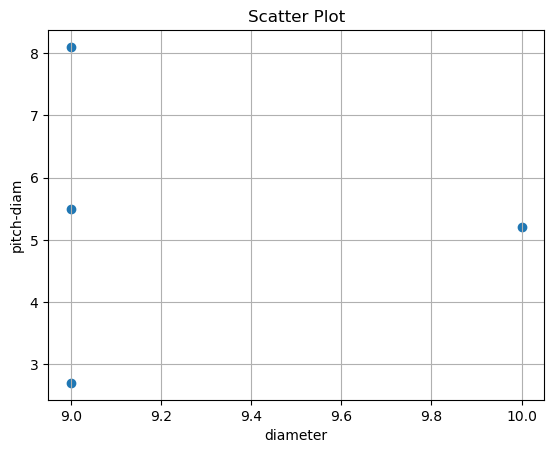

In [283]:
# Scatter plot of 'diameter' and 'pitch-diameter'
plt.scatter(df_final_candidates['diameter'], df_final_candidates['pitch-diam'])
plt.xlabel('diameter')
plt.ylabel('pitch-diam')
plt.title('Scatter Plot')
plt.grid(True)
plt.show()

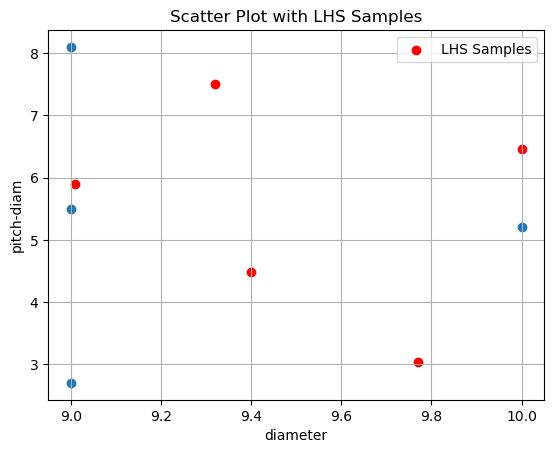

In [286]:
# LHS within the range
# Define the range for sampling 
min_diameter = min(df_final_candidates['diameter'])
max_diameter = max(df_final_candidates['diameter'])
min_pitch_diam = min(df_final_candidates['pitch-diam'])
max_pitch_diam = max(df_final_candidates['pitch-diam'])

# Number of samples to generate
num_samples = 5

# Generate Latin Hypercube Samples
lhs_samples = lhs(2, samples=num_samples, criterion="maximin")

# Scale the samples to the range of the original data and round to two decimal places
lhs_samples[:, 0] = np.around(lhs_samples[:, 0] * (max_diameter - min_diameter) + min_diameter, 2)
lhs_samples[:, 1] = np.around(lhs_samples[:, 1] * (max_pitch_diam - min_pitch_diam) + min_pitch_diam, 2)

# Plot the LHS samples
plt.scatter(df_final_candidates['diameter'], df_final_candidates['pitch-diam'])
plt.scatter(lhs_samples[:, 0], lhs_samples[:, 1], color='red', label='LHS Samples')
plt.xlabel('diameter')
plt.ylabel('pitch-diam')
plt.title('Scatter Plot with LHS Samples')
plt.grid(True)
plt.legend()
plt.show()

In [287]:
lhs_samples

array([[9.010, 5.900],
       [10.000, 6.460],
       [9.770, 3.030],
       [9.320, 7.510],
       [9.400, 4.480]])

In [288]:
# Geometry Parameters
new_values_df = pd.DataFrame(lhs_samples, columns=['diameter', 'pitch-diam'])
diam_pitch_df = pd.concat([df_final_candidates[['diameter', 'pitch-diam']], new_values_df], ignore_index=True)  
diam_pitch_df ['diameter'] = diam_pitch_df ['diameter'].round()
diam_pitch_df

,diameter,pitch-diam
0,9.0,2.70
1,9.0,5.50
2,9.0,8.10
3,10.0,5.20
4,9.0,5.90
5,10.0,6.46
6,10.0,3.03
7,9.0,7.51
8,9.0,4.48


In [289]:
# Concatenate the DataFrame with itself four times (Four Samples/Four sets of Growth Parameters)
diam_pitch_all_df = pd.concat([diam_pitch_df] * 4, ignore_index=True)
diam_pitch_all_df

,diameter,pitch-diam
0,9.0,2.70
1,9.0,5.50
2,9.0,8.10
3,10.0,5.20
4,9.0,5.90
5,10.0,6.46
6,10.0,3.03
7,9.0,7.51
8,9.0,4.48
9,9.0,2.70


In [290]:
# Replicate nine times (nine sets of Geometry parameters)
subset_cols = ['nQWs', 'growt_T_qw', 'growt_AsP_qw', 'growth_InP_br_V_III', 'growt_t_cap']
df_wafer = df_final_candidates[subset_cols].copy()

# Select subset columns and replicate the DataFrame nine times
df_wafer = df_wafer.loc[df_wafer.index.repeat(9)].reset_index(drop=True)

df_wafer

,nQWs,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,9.0,590.0,0.92,1846.0,198.0
1,9.0,590.0,0.92,1846.0,198.0
2,9.0,590.0,0.92,1846.0,198.0
3,9.0,590.0,0.92,1846.0,198.0
4,9.0,590.0,0.92,1846.0,198.0
5,9.0,590.0,0.92,1846.0,198.0
6,9.0,590.0,0.92,1846.0,198.0
7,9.0,590.0,0.92,1846.0,198.0
8,9.0,590.0,0.92,1846.0,198.0
9,9.0,594.0,0.92,1669.0,221.0


In [291]:
# Joining the two DataFrames vertically- Growth and Geometry Parameters-final Set 
df_param_final = pd.concat([diam_pitch_all_df, df_wafer], axis=1)
df_param_final

,diameter,pitch-diam,nQWs,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,9.0,2.70,9.0,590.0,0.92,1846.0,198.0
1,9.0,5.50,9.0,590.0,0.92,1846.0,198.0
2,9.0,8.10,9.0,590.0,0.92,1846.0,198.0
3,10.0,5.20,9.0,590.0,0.92,1846.0,198.0
4,9.0,5.90,9.0,590.0,0.92,1846.0,198.0
5,10.0,6.46,9.0,590.0,0.92,1846.0,198.0
6,10.0,3.03,9.0,590.0,0.92,1846.0,198.0
7,9.0,7.51,9.0,590.0,0.92,1846.0,198.0
8,9.0,4.48,9.0,590.0,0.92,1846.0,198.0
9,9.0,2.70,9.0,594.0,0.92,1669.0,221.0


In [292]:
# Do Predictions
# Convert pandas DataFrame to torch tensor
tensor_par = torch.tensor(df_param_final.values)
par_norm = normalize(tensor_par, problem_bounds)

with torch.no_grad():
    posterior = model.posterior(par_norm)  
    y_pred_all = posterior.mean.squeeze()
    lower, upper = posterior.mvn.confidence_region()
    y_err_all = upper-lower

y_pred_all[:,0] = -y_pred_all[:,0]


obj_pred = y_pred_all.cpu().numpy()


obj_err =   y_err_all.cpu().numpy()

subset_col_pred = ['Predicted_Thresh', 'Predicted Wavelength','Predicted_Yield']
Optimized_df_all_pred = pd.DataFrame(obj_pred, columns=subset_col_pred)
Optimized_df_all_pred

,Predicted_Thresh,Predicted Wavelength,Predicted_Yield
0,234.404766,1034.068234,0.871325
1,189.221648,1087.472685,1.010878
2,159.559481,1170.135515,0.938764
3,197.701400,1076.261344,0.982409
4,182.486227,1102.253712,1.009921
5,176.884269,1122.388077,0.976578
6,232.150418,1036.035822,0.881380
7,162.543258,1161.514372,0.963390
8,207.287014,1056.907541,0.983994
9,237.488439,1034.362597,0.854498


## Final Dataset of Optimized Parameters

In [92]:
# Function to merge rows within each group
def merge_rows(group, group_name):
    # Sort the group by column 'B'
    group_sorted = group.sort_values(by='diameter').reset_index(drop=True)
    
    # Initialize the Group column with empty strings
    group_sorted['Sample'] = ''
    
    # Set the Group column for the first row of each group
    group_sorted.at[0, 'Sample'] = group_name
    
    return group_sorted

# Initialize a counter for group names
wafer_counter = ord('G')

# Function to apply to each group
def apply_merge_rows(group):
    global wafer_counter
    group_name = f"Sample {chr(wafer_counter)}"
    result = merge_rows(group, group_name)
    wafer_counter += 1
    return result

# Apply the merge_rows function to each group
df_grouped_sorted = df_param_final.groupby('growth_InP_br_V_III', group_keys=False).apply(apply_merge_rows).reset_index(drop=True)

# Reorder columns to place 'Group' first
cols = ['Sample'] + [col for col in df_grouped_sorted.columns if col != 'Sample']
df_grouped_sorted = df_grouped_sorted[cols]
df_grouped_sorted

C:\Users\m89098ma\AppData\Local\Temp\ipykernel_5112\1961499857.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped_sorted = df_param_final.groupby('growth_InP_br_V_III', group_keys=False).apply(apply_merge_rows).reset_index(drop=True)


,Sample,diameter,pitch-diam,nQWs,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,Sample G,9.0,2.70,9.0,595.0,0.88,1612.0,212.0
1,,9.0,5.50,9.0,595.0,0.88,1612.0,212.0
2,,9.0,8.10,9.0,595.0,0.88,1612.0,212.0
3,,9.0,5.90,9.0,595.0,0.88,1612.0,212.0
4,,9.0,7.51,9.0,595.0,0.88,1612.0,212.0
5,,9.0,4.48,9.0,595.0,0.88,1612.0,212.0
6,,10.0,5.20,9.0,595.0,0.88,1612.0,212.0
7,,10.0,6.46,9.0,595.0,0.88,1612.0,212.0
8,,10.0,3.03,9.0,595.0,0.88,1612.0,212.0
9,Sample H,9.0,2.70,8.0,596.0,0.91,1643.0,225.0


In [54]:
# Save MOBO Dataset
df_grouped_sorted.to_csv('MOBO_paramaters.csv', index=False)
df_grouped_sorted.describe()

,diameter,pitch-diam,nQWs,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,9.333333,5.431111,8.750000,593.750000,0.907500,1692.500000,214.000000
std,0.478091,1.753699,0.439155,2.309917,0.016626,92.180723,10.515295
min,9.000000,2.700000,8.000000,590.000000,0.880000,1612.000000,198.000000
25%,9.000000,4.480000,8.750000,593.000000,0.902500,1635.250000,208.500000
50%,9.000000,5.500000,9.000000,594.500000,0.915000,1656.000000,216.500000
75%,10.000000,6.460000,9.000000,595.250000,0.920000,1713.250000,222.000000
max,10.000000,8.100000,9.000000,596.000000,0.920000,1846.000000,225.000000


# PCA-DoE

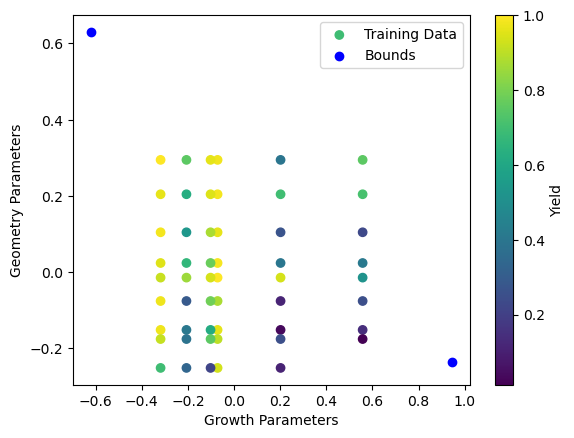

In [82]:
# Fit & transform growth parameters into one principal component
pca_wafer = PCA(n_components=1, random_state=42).fit(train_x_norm.cpu().numpy()[:,[1,3,4,5,6]])
orig_wafer = pca_wafer.transform(train_x_norm.cpu().numpy()[:,[1,3,4,5,6]])

# Fit & transform geometry Paarmeters into one principal component
pca_array = PCA(n_components=1, random_state=42).fit(train_x_norm.cpu().numpy()[:,[0,2]])
orig_array = pca_array.transform(train_x_norm.cpu().numpy()[:,[0,2]])

# Convert standard bounds (problem bounds in PCA space)
prob_wafer = pca_wafer.transform(standard_bounds.cpu().numpy()[:,[1,3,4,5,6]])
prob_array = pca_array.transform(standard_bounds.cpu().numpy()[:,[0,2]])

# Plot
sc= plt.scatter(orig_wafer, orig_array, label='Training Data', cmap='viridis', c=df['Yield'])
plt.scatter(prob_wafer, prob_array, label='Bounds', c='b')
plt.colorbar(sc, label='Yield')
plt.xlabel('Growth Parameters')
plt.ylabel('Geometry Parameters')
plt.legend()
plt.show()

In [58]:
# Number of fields 
num_samples_per_group = 7

# Generate LHS samples for X = -0.6 (Near to one of the extreme bounds)
lhs_doe= lhs(1, samples=num_samples_per_group)
lhs_doe= lhs_doe * (0.6) - 0.2  # Adjusting range to be -0.6 to 1.0
lhs_doe = np.hstack((np.full((num_samples_per_group, 1), -0.6), lhs_doe))

# Printing the data
print("Samples at X = (-0.6):")
print(lhs_doe)

Samples at X = (-0.6):
[[-0.600 0.326]
 [-0.600 0.068]
 [-0.600 -0.092]
 [-0.600 0.006]
 [-0.600 0.299]
 [-0.600 0.178]
 [-0.600 -0.126]]


In [103]:
# Now the first column will be growth parameters and the second column will be geometry parameters in PCA space
doe_sample_param = lhs_doe[:,0].reshape(-1, 1) # Reshape to ensure it's a single column (if required)
doe_field_param = lhs_doe[:,1].reshape(-1, 1)

# Inverse transform back to normalized values
candidates_sample_doe = pca_wafer.inverse_transform(doe_sample_param)
candidates_field_doe = pca_array.inverse_transform(doe_field_param)

candidates_all_doe = np.hstack((candidates_field_doe, candidates_sample_doe))
# Rearrange second and third columns
candidates_all_doe[:, [1, 2]] = candidates_all_doe[:, [2, 1]]

# unnormalize candidates within the problem bounds
candidates_all_doe_unnorm = unnormalize(torch.tensor(candidates_all_doe), problem_bounds)
df_candidates_doe = pd.DataFrame(candidates_all_doe_unnorm, columns=df.columns[3:])
df_candidates_doe

,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,10.388176,8.384608,3.367541,598.248824,1.105601,1714.623328,242.647448
1,7.572346,8.384608,3.785948,598.248824,1.105601,1714.623328,242.647448
2,5.826094,8.384608,4.045426,598.248824,1.105601,1714.623328,242.647448
3,6.895673,8.384608,3.886496,598.248824,1.105601,1714.623328,242.647448
4,10.093496,8.384608,3.411327,598.248824,1.105601,1714.623328,242.647448
5,8.772893,8.384608,3.607557,598.248824,1.105601,1714.623328,242.647448
6,5.455016,8.384608,4.100565,598.248824,1.105601,1714.623328,242.647448


In [104]:
# Predictions for DoE
# Convert pandas DataFrame to torch tensor
tensor_par_doe = torch.tensor(df_candidates_doe.values)
par_doe = normalize(tensor_par_doe, problem_bounds)

with torch.no_grad():
    posterior_doe = model.posterior(par_doe)  
    y_pred_doe = posterior_doe.mean.squeeze()
    lower, upper = posterior_doe.mvn.confidence_region()
    y_err_doe = upper-lower

y_pred_doe[:,0] = -y_pred_doe[:,0]


obj_pred_doe = y_pred_doe.cpu().numpy()


obj_err_doe =   y_err_doe.cpu().numpy()

subset_col_pred = ['Predicted_Thresh_DoE', 'Predicted Wavelength_DoE','Predicted_DoE']
df_doe_pred = pd.DataFrame(obj_pred_doe, columns=subset_col_pred)
df_doe_pred

,Predicted_Thresh_DoE,Predicted Wavelength_DoE,Predicted_DoE
0,207.272585,1130.386928,0.964747
1,233.937910,1115.899438,0.977023
2,273.312175,1084.338836,0.924306
3,247.408510,1105.558102,0.962910
4,208.049868,1130.808417,0.969927
5,216.943564,1127.492269,0.983590
6,283.098725,1075.950945,0.906801


In [105]:
# Process dataframe according to required number of significant digits
df_candidates_doe = process_dataframe(df_candidates_doe)
df_candidates_doe

,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,10.0,8.0,3.4,598.0,1.1,1715.0,243.0
1,8.0,8.0,3.8,598.0,1.1,1715.0,243.0
2,6.0,8.0,4.0,598.0,1.1,1715.0,243.0
3,7.0,8.0,3.9,598.0,1.1,1715.0,243.0
4,10.0,8.0,3.4,598.0,1.1,1715.0,243.0
5,9.0,8.0,3.6,598.0,1.1,1715.0,243.0
6,5.0,8.0,4.1,598.0,1.1,1715.0,243.0


In [106]:
# Add the 'Sample' column with 'DoE' in the first row 
df_candidates_doe.insert(0, 'Sample', ['DoE'] + [''] * (len(df_candidates_doe) - 1))
df_candidates_doe

,Sample,diameter,nQWs,pitch-diam,growt_T_qw,growt_AsP_qw,growth_InP_br_V_III,growt_t_cap
0,DoE,10.0,8.0,3.4,598.0,1.1,1715.0,243.0
1,,8.0,8.0,3.8,598.0,1.1,1715.0,243.0
2,,6.0,8.0,4.0,598.0,1.1,1715.0,243.0
3,,7.0,8.0,3.9,598.0,1.1,1715.0,243.0
4,,10.0,8.0,3.4,598.0,1.1,1715.0,243.0
5,,9.0,8.0,3.6,598.0,1.1,1715.0,243.0
6,,5.0,8.0,4.1,598.0,1.1,1715.0,243.0


In [107]:
df_candidates_doe.to_csv('DoE_paramaters.csv', index=False)